In [2]:
!pip install opencv-python

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


# 컬러 영상 영역분할

공개SW협회의 주관의 Open Up의 인공지능“이미지의 사물 검출에 딥러닝 활용(심화)”전문교육 프로그램중의 교재를 가져와서 수정함

https://edu.kosslab.kr/course/view.php?id=34


In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import os
import random
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow import keras as K
from tensorflow.keras.utils import plot_model

# 데이터 준비

## 데이터 다운로드

http://www.robots.ox.ac.uk/~vgg/data/pets/ 의 데이터를 사용.

In [ ]:
# %%shell
# wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2020-09-08 13:29:41--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  96.9MB/s    in 7.8s    

2020-09-08 13:29:48 (96.4 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2020-09-08 13:29:48--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  72.9MB/s    in 0.3s    

2020-09-08 13:29:49 (72.9 MB/s)

## 압축 풀기

In [ ]:
# %%shell
# tar -xvzf images.tar.gz
# tar -xvzf annotations.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

## 불필요한 파일 삭제

In [ ]:
# !rm images/*.mat
# !rm annotations/trimaps/._*

In [ ]:
# 프롬프트창에서 실행
cd 'C:\Study\Python\Jupyter\DMC_Class\DeepLearning\data\images'
rm *.mat

cd 'C:\Study\Python\Jupyter\DMC_Class\DeepLearning\data\annotations\trimaps'
rm ._*

## 풀린 데이터 파일 구조

```
images/
  Abyssinian_1.jpg
  Abyssinian_10.jpg
  Abyssinian_100.jpg
  ...
annotations/
  trimaps/
    Abyssinian_1.png
    Abyssinian_10.png
    Abyssinian_100.png
    ...
  xmls/            # 사용한함.  PASCAL VOC Format의 object dtection 레이블
    Abyssinian_1.xml
    Abyssinian_10.xml
    Abyssinian_100.xml
    ...
  README           # 사용 안한
  list.txt         # 사용 안함
  test.txt         # 사용 안함
  trainval.txt     # 사용 안함
```

In [ ]:
# %%shell
# ls -al images/ | head
# ls -al annotations/trimaps/ | head

total 789100
drwxr-xr-x 2 1001 1001  290816 Sep  8 13:30 .
drwxr-xr-x 1 root root    4096 Sep  8 13:29 ..
-rwxr-xr-x 1 1001 1001  126923 Jun 18  2012 Abyssinian_100.jpg
-rwxr-xr-x 1 1001 1001   49023 Jun 18  2012 Abyssinian_101.jpg
-rwxr-xr-x 1 1001 1001  165505 Jun 18  2012 Abyssinian_102.jpg
-rwxr-xr-x 1 1001 1001  132937 Jun 18  2012 Abyssinian_103.jpg
-rwxr-xr-x 1 1001 1001   34907 Jun 18  2012 Abyssinian_104.jpg
-rwxr-xr-x 1 1001 1001  141823 Jun 18  2012 Abyssinian_105.jpg
-rwxr-xr-x 1 1001 1001  197092 Jun 18  2012 Abyssinian_106.jpg
total 31136
drwxr-xr-x 2 501 staff 634880 Sep  8 13:30 .
drwxr-xr-x 4 501 staff   4096 Jun 30  2012 ..
-rwxr-xr-x 1 501 staff   3555 Jun 18  2012 Abyssinian_100.png
-rwxr-xr-x 1 501 staff   2468 Jun 18  2012 Abyssinian_101.png
-rwxr-xr-x 1 501 staff   3554 Jun 18  2012 Abyssinian_102.png
-rwxr-xr-x 1 501 staff   2791 Jun 18  2012 Abyssinian_103.png
-rwxr-xr-x 1 501 staff   3602 Jun 18  2012 Abyssinian_104.png
-rwxr-xr-x 1 501 staff   2521 Jun 18  20

## 파일 보기

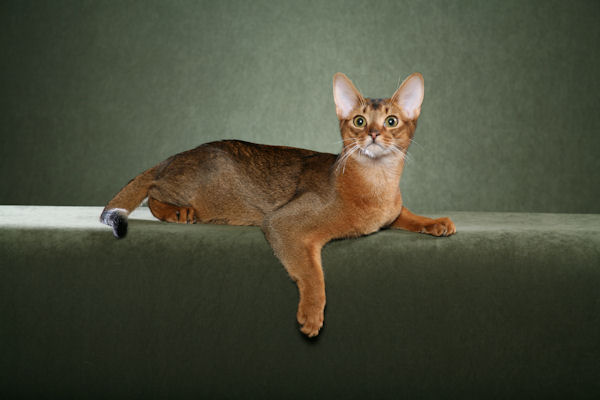

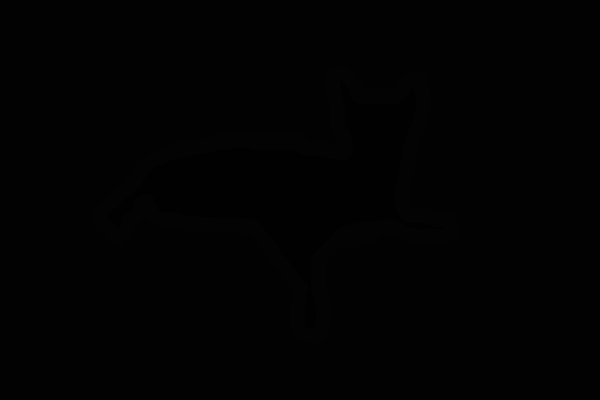

In [2]:
from IPython.display import Image, display

display(Image('data/images/Abyssinian_1.jpg'))
display(Image('data/annotations/trimaps/Abyssinian_1.png'))


annoation 파일은 일반 이미지 파일이 아니고, 각 픽셀별 category 값이 담긴 파일이다.
그냥 봐서는 보이지 않는다.

(400, 600)


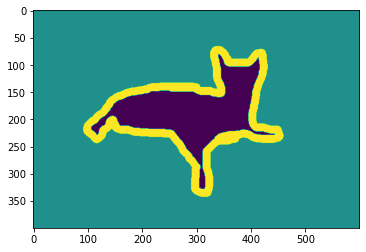

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3]


In [3]:
label = cv2.imread('data/annotations/trimaps/Abyssinian_1.png', cv2.IMREAD_GRAYSCALE)
print(label.shape)
plt.imshow(label)
plt.show()
print(label[100][300:360])

category 값은 README 파일에 명시되어 있다.
- 1: 전경
- 2: 배경
- 3: 이외

# ImageDataGenerator 선언

keras의 ImageDataGenerator를 사용하여 파일을 읽는다.

파일의 크기가 제각각이라 256x256 사이즈로 로딩한다.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_preprocessor(image):
  # normalizing
  return image/255.0

def label_preprocessor(label):
  # 전경/배경/이외의 구분을 전경/배경으로 바꾼다.
  label[ label==1 ] = 1  # 전경(1)은 1로  
  label[ label==2 ] = 0  # 배경(2)은 0으로
  label[ label==3 ] = 1  # 이외(3)도 1로. 전경의 테두리 같다. 전경으로 치자.
  return label


img_generator = ImageDataGenerator(
    preprocessing_function=image_preprocessor,
    validation_split=0.2) # validation_split: Float. Fraction of images reserved 
                          # for validation (strictly between 0 and 1).


train_img_generator = img_generator.flow_from_directory("data/", 
    classes=["images"],   # Optional list of class subdirectories (e.g. ['dogs', 'cat])s'])
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",  # 타켓 사이즈가 다르면 근처값으로 맞춰줌
    class_mode=None,
    shuffle=True,
    subset='training',   # Subset of data ("training" or "validation") 
                         # if validation_split is set in ImageDataGenerator.
    seed=42)

validation_img_generator = img_generator.flow_from_directory("data/",
    classes=["images"],
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    class_mode=None,
    shuffle=True,
    subset='validation',
    seed=42)



label_generator = ImageDataGenerator(
    preprocessing_function=label_preprocessor,
    validation_split=0.2)


train_label_generator = label_generator.flow_from_directory(
    "data/annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=42)


validation_label_generator = label_generator.flow_from_directory(
    "data/annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    subset='validation',  
    seed=42)

train_data_generator = zip(train_img_generator, train_label_generator)
validation_data_generator = zip(validation_img_generator, validation_label_generator)



Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.
Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.


### zip

In [9]:
list_a = [ 1, 2, 3, 4 ]
list_b = ["a", "b", "c", "d"]

for a, b in zip(list_a, list_b):
    print(a, b)

1 a
2 b
3 c
4 d


## 데이터 살펴보기

In [7]:
batch_x, batch_y = next(train_data_generator)  # batch_size 만큼 꺼냄

print(batch_x.shape)
print(batch_y.shape)

(64, 256, 256, 3)
(64, 256, 256, 1)


In [8]:
print(batch_x[0])
print(batch_y[0])

[[[0.77254903 0.68235296 0.61960787]
  [0.7921569  0.7019608  0.6392157 ]
  [0.77254903 0.6901961  0.6156863 ]
  ...
  [0.49411765 0.30980393 0.14509805]
  [0.52156866 0.31764707 0.16470589]
  [0.5294118  0.3254902  0.17254902]]

 [[0.78039217 0.69803923 0.6313726 ]
  [0.78039217 0.69803923 0.6313726 ]
  [0.7882353  0.7137255  0.64705884]
  ...
  [0.56078434 0.35686275 0.2       ]
  [0.5529412  0.34509805 0.17254902]
  [0.54509807 0.3372549  0.16470589]]

 [[0.7882353  0.7058824  0.6392157 ]
  [0.78039217 0.7058824  0.6392157 ]
  [0.7921569  0.7176471  0.65882355]
  ...
  [0.5568628  0.34901962 0.19215687]
  [0.54901963 0.34117648 0.16862746]
  [0.5647059  0.35686275 0.18431373]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         0.99215686]
  [0.99607843 1.         0.9764706 ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]


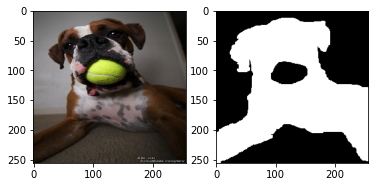

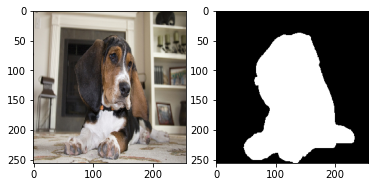

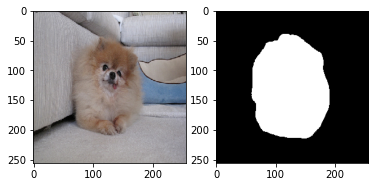

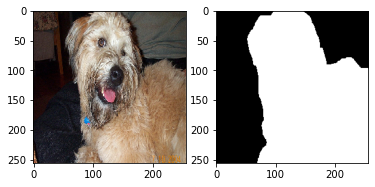

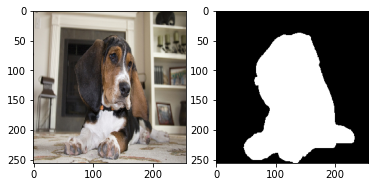

In [9]:
import matplotlib.pyplot as plt

def plotTrainData(x, y):
    for i in range(5):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
   
plotTrainData(batch_x, batch_y)

# U-Net 모델 정의

In [10]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

# 모델 컴파일과 학습

In [11]:
model = unet()

model.compile(optimizer = 'rmsprop', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
hist = model.fit_generator(
    train_data_generator,    # (inputs, targets) 튜플
    steps_per_epoch=train_img_generator.samples/64,
    validation_data=validation_data_generator,     
     # ImageDataGenerator에서 validation_split을 설정하고 validation_data_generator를
     # 만들어서 validation_data에 넣어주면 validation_split에서 설정한 값만큼 데이터를 따로
     # 저장해두었다가 validation_data_generator에서 사용하는 것 같다. (추측)
     # train/validation 모두 같은 폴더에서 가져온 data임을 명심하자
     # validation data 폴더를 따로 구성할 필요가 없다.
    validation_steps=validation_img_generator.samples/64,
    epochs=100, 
    verbose=1)

C:\Users\JuNoe\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
92/92 [==============================] - 57s 516ms/step - loss: 12.3736 - val_loss: 0.5510
Epoch 2/100
92/92 [==============================] - 42s 454ms/step - loss: 0.5673 - val_loss: 0.6085
Epoch 3/100
92/92 [==============================] - 42s 457ms/step - loss: 0.5698 - val_loss: 0.5669
Epoch 4/100
92/92 [==============================] - 40s 434ms/step - loss: 0.5158 - val_loss: 0.5265
Epoch 5/100
92/92 [==============================] - 40s 438ms/step - loss: 0.4818 - val_loss: 0.5080
Epoch 6/100
92/92 [==============================] - 40s 434ms/step - loss: 0.4474 - val_loss: 0.5286
Epoch 7/100
92/92 [==============================] - 40s 438ms/step - loss: 0.4171 - val_loss: 0.5989
Epoch 8/100
92/92 [==============================] - 40s 437ms/step - loss: 0.3770 - val_loss: 0.4787
Epoch 9/100
92/92 [==============================] - 40s 437ms/step - loss: 0.3474 - val_loss: 0.5213
Epoch 10/100
92/92 [==============================] - 40s 435ms/step - loss: 0.32

92/92 [==============================] - 44s 482ms/step - loss: 0.0410 - val_loss: 0.4650
Epoch 81/100
92/92 [==============================] - 44s 478ms/step - loss: 0.0419 - val_loss: 0.5132
Epoch 82/100
92/92 [==============================] - 43s 468ms/step - loss: 0.0396 - val_loss: 0.5646
Epoch 83/100
92/92 [==============================] - 43s 468ms/step - loss: 0.0402 - val_loss: 0.4727
Epoch 84/100
92/92 [==============================] - 43s 467ms/step - loss: 0.0412 - val_loss: 0.4872
Epoch 85/100
92/92 [==============================] - 43s 471ms/step - loss: 0.0385 - val_loss: 0.5788
Epoch 86/100
92/92 [==============================] - 43s 468ms/step - loss: 0.0378 - val_loss: 0.5328
Epoch 87/100
92/92 [==============================] - 43s 469ms/step - loss: 0.0368 - val_loss: 0.5651
Epoch 88/100
92/92 [==============================] - 43s 470ms/step - loss: 0.0367 - val_loss: 0.6306
Epoch 89/100
92/92 [==============================] - 43s 469ms/step - loss: 0.0381 - 

## 로스 보기

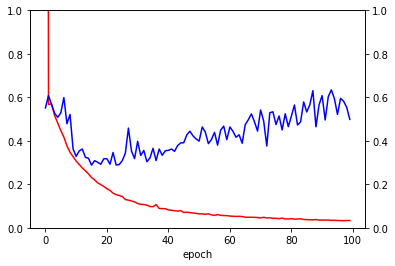

In [13]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'r')
loss_ax.plot(hist.history['val_loss'], 'b')
loss_ax.set_ylim([0.0, 1.0])


loss_ax.set_xlabel('epoch')

plt.show()

## 테스트 결과 보기

In [14]:
import matplotlib.pyplot as plt

def plotPredictions(model, x, y):

  predicted = model.predict(x)
  predicted = (predicted > 0.5).astype(np.uint8)

  for i in range(5):

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("image")
    plt.axis('off')
    plt.imshow(x[i])
    plt.subplot(1,3,2)
    plt.title("label")
    plt.axis('off')
    plt.imshow(y[i].squeeze(), 'gray')
    plt.subplot(1,3,3)
    plt.title("predicted")    
    plt.axis('off')
    plt.imshow(predicted[i].squeeze(), 'gray')
    plt.show()

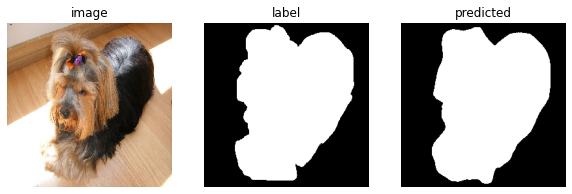

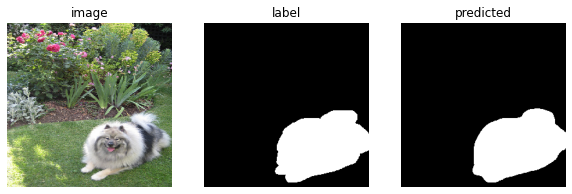

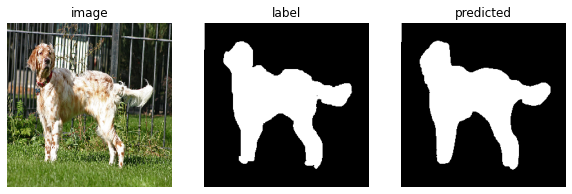

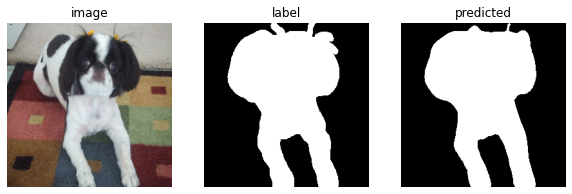

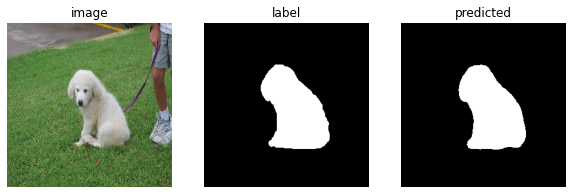

In [15]:
plotPredictions(model, batch_x, batch_y)